Compiling model...
'compile' took 0.000447 s



Training model...

0         [1.54e+01, 5.62e+00]    [1.54e+01, 5.62e+00]    [9.93e+00]    
1000      [6.64e-03, 1.31e-06]    [6.53e-03, 1.31e-06]    [5.40e+00]    
2000      [9.51e-04, 1.09e-07]    [9.35e-04, 1.09e-07]    [5.40e+00]    
3000      [4.55e-05, 6.37e-08]    [4.44e-05, 6.38e-08]    [5.40e+00]    
4000      [1.32e-05, 1.38e-07]    [1.27e-05, 1.38e-07]    [5.40e+00]    
5000      [1.24e-04, 3.56e-05]    [1.21e-04, 3.56e-05]    [5.39e+00]    
6000      [2.24e-05, 7.29e-07]    [2.19e-05, 7.28e-07]    [5.40e+00]    
7000      [3.57e-04, 1.47e-05]    [3.51e-04, 1.47e-05]    [5.39e+00]    
8000      [9.52e-05, 4.89e-04]    [9.23e-05, 4.89e-04]    [5.40e+00]    
9000      [2.16e-03, 1.64e-04]    [2.12e-03, 1.64e-04]    [5.40e+00]    
10000     [7.18e-05, 1.73e-05]    [7.02e-05, 1.73e-05]    [5.40e+00]    

Best model at step 4000:
  train loss: 1.33e-05
  test loss: 1.29e-05
  test metric: [5.40e+00]

'train' took 56.683757 s



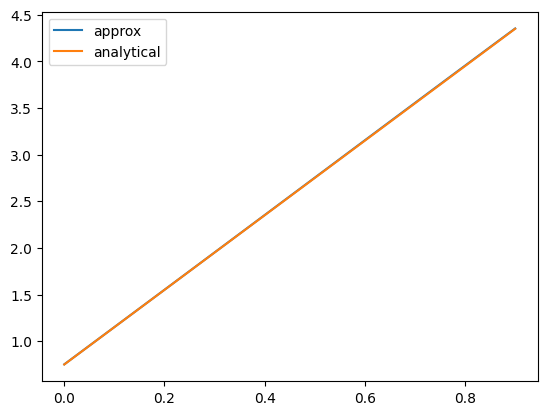

In [20]:
import deepxde as dde
from deepxde.backend import tf
import numpy as np
from scipy.integrate import solve_ivp
import torch
import math

#dde.optimizers.set_LBFGS_options(maxiter=500)

geom = dde.geometry.TimeDomain(0, 0.9)

def derivatives_fnc(t, u):
    # if isinstance(t, torch.Tensor):
    #     du_dt = 4*u - 6*u**2 + torch.sin(50*t) + u*torch.cos(25*t) - 0.5
    # else:
    #     du_dt = 4*u - 6*u**2 + math.sin(50*t) + u*math.cos(25*t) - 0.5
    # return du_dt
    if isinstance(t, torch.Tensor):
        du_dt = 4 
    else:
        du_dt = 4
    return du_dt


def function_res(t, u):
    du_dt = dde.grad.jacobian(u, t)
    res = du_dt - derivatives_fnc(t,u[0])
    return res

def boundary(x, _):
    return dde.utils.isclose(x[0], 0)

def boundary_value(x):
    return 0.75

bc = dde.icbc.IC(geom, boundary_value, boundary)

analytical_solution = solve_ivp(derivatives_fnc, [0,0.9], [0.75], dense_output=True)

def sol(t):
    return analytical_solution.sol(t.squeeze())

data = dde.data.PDE(geom, function_res, bc, 1000, 1, solution=sol, num_test=100)

layer_size = [1] + [150] * 6 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(layer_size, activation, initializer)

boundary_scaling = 10.0

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"], loss_weights=[1,boundary_scaling])
# model.compile("L-BFGS", metrics=["l2 relative error"], loss_weights=[1,boundary_scaling])

class PrintLossCallback(dde.callbacks.Callback):
    """
    Custom callback
    """  
    def __init__(self):
        super().__init__()

    def on_epoch_end(self):
        pass
        #print("Loss")
            
print_loss_callback = PrintLossCallback()
timer_callback = dde.callbacks.Timer(10)

#losshistory, train_state = model.train( callbacks=[timer_callback, print_loss_callback])
losshistory, train_state = model.train(iterations=10000)

#dde.saveplot(losshistory, train_state, issave=False, isplot=True)

import matplotlib.pyplot as plt

t = np.linspace(0,0.9,100)
u_pred = [model.predict([i]) for i in t]
plt.plot(t, u_pred)
plt.plot(t, sol(t).T)
plt.legend(["approx","analytical"])